In [2]:
# CHEST X RAY PNEUMONIA PREDICTION
# created 13 July 2020
# --------------------------------------------

# DATA HANDLING
# directory variable
import os
base = 'dataxray'
directory_train = os.path.join(base,'train')
directory_test = os.path.join(base,'test')
directory_val = os.path.join(base,'val')

train_N = os.path.join(directory_train,'NORMAL')
train_P = os.path.join(directory_train,'PNEUMONIA')

test_N = os.path.join(directory_test,'NORMAL')
test_P = os.path.join(directory_test,'PNEUMONIA')

val_N = os.path.join(directory_val,'NORMAL')
val_P = os.path.join(directory_val,'PNEUMONIA')

print('DATASET CHEST XRAY')
print('number of images')
print('-----------------------------------')
print('Train (normal, pneumonia)',len(os.listdir(train_N)), len(os.listdir(train_P)))
print('Test (normal, pneumonia)',len(os.listdir(test_N)), len(os.listdir(test_P)))
print('Val (normal, pneumonia)',len(os.listdir(val_N)), len(os.listdir(val_P)))

DATASET CHEST XRAY
number of images
-----------------------------------
Train (normal, pneumonia) 1341 3875
Test (normal, pneumonia) 234 390
Val (normal, pneumonia) 8 8


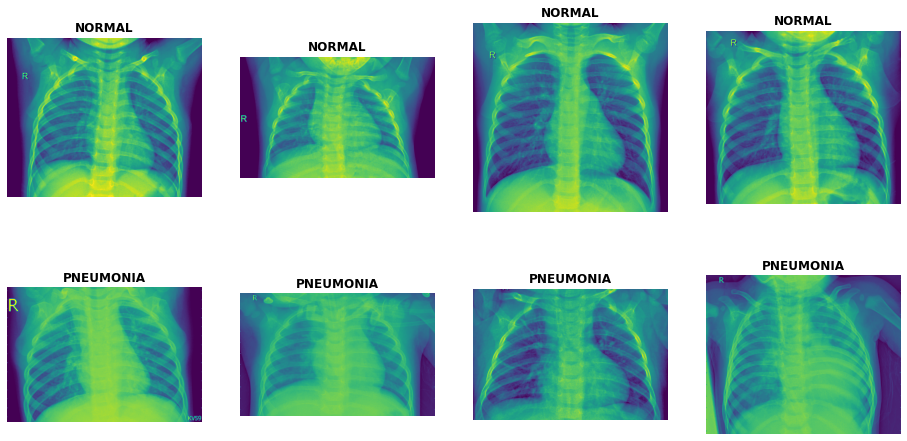

In [6]:
# INSPECT RAW DATA BEFORE AUGMENT
import matplotlib.pyplot as plt
import tensorflow as tf

nrows = 2
ncols = 4
img_index = int(nrows*ncols / 2)

# Set up matplotlib fig, and size it to fit 2x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

# Pick random image from train melanoma
normal_fnames = os.listdir(train_N)
normal_fnames = (tf.random.shuffle(normal_fnames)[:img_index]).numpy()
normal_fnames = [tf.compat.as_str(fname) for fname in normal_fnames]
normal_images = [os.path.join(train_N, fname) 
                for fname in normal_fnames]

# Pick random image from train not melanoma
pneumonia_fnames = os.listdir(train_P)
pneumonia_fnames = (tf.random.shuffle(pneumonia_fnames)[:img_index]).numpy()
pneumonia_fnames = [tf.compat.as_str(fname) for fname in pneumonia_fnames]
pneumonia_images = [os.path.join(train_P, fname) 
                for fname in pneumonia_fnames]

for i, img_path in enumerate(normal_images + pneumonia_images):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off') # Don't show axes (or gridlines)
    if i < len(normal_images):
        plt.title('NORMAL', fontweight='bold')
    else:
        plt.title('PNEUMONIA', fontweight='bold')
    img = plt.imread(img_path)
    plt.imshow(img)

plt.show()

DATASET CHEST XRAY
number of images
-----------------------------------
Train (normal, pneumonia) 1341 3875
Test (normal, pneumonia) 234 390
Val (normal, pneumonia) 8 8
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


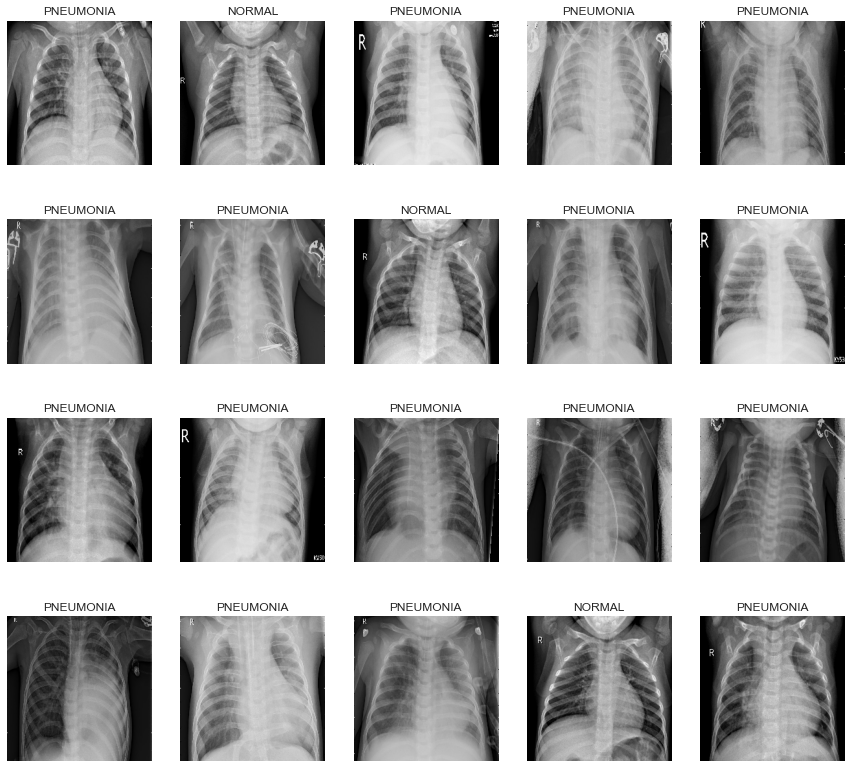

In [1]:
# IMAGE AUGMENTATION - DATA GENERATOR
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 20
target_size = (224, 224)
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/255)
validation_datagen = ImageDataGenerator(rescale = 1.0/255)
test_datagen  = ImageDataGenerator(rescale = 1.0/255)
# Specify the image classes
classes = ['NORMAL', 'PNEUMONIA']
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(directory_train,
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    classes=classes,
                                                    target_size=target_size)     
# Flow validation images in batches of 20 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(directory_val,
                                                            batch_size=batch_size,
                                                            class_mode='binary',
                                                            classes=classes,
                                                            target_size=target_size)
# Flow testing images in batches of 100 using test_datagen generator
test_generator = test_datagen.flow_from_directory(directory_test,
                                                  batch_size=batch_size,
                                                  class_mode='binary',
                                                  classes=classes,
                                                  target_size=target_size)


# PREVIEW IMAGES DATA (after augmentation)
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import tensorflow as tf
# Obtain one batch of testing images
images, labels = next(train_generator)
labels = labels.astype('int')
# Plot the images in the batch, along with predicted and true labels
nrows = 4
ncols = batch_size / nrows
fig = plt.figure(figsize=(15, 14))
for idx in range(20):
    ax = fig.add_subplot(nrows, ncols, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [3]:
base_model = InceptionV3(input_shape=(224,224,3), include_top=False)

87916544/87910968 [==============================] - 93s 1us/step


In [4]:
feature_batch = base_model(images)
print(feature_batch.shape)

(20, 5, 5, 2048)


In [5]:
base_model.trainable = False
print(base_model.summary())

[0]              
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 12, 12, 192)  147456      average_pooling2d_6[0][0]        
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 12, 12, 192)  576         conv2d_60[0][0]                  
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 12, 12, 192)  576         conv2d_63[0][0]                  
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 12, 12, 192)  576         conv2d_68[0][0]                  
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 12, 12, 192)  576         conv2d_69[0][0]           

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.layers import InputLayer, GlobalAveragePooling2D, ReLU, Add, DepthwiseConv2D
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop, SGD
from tensorflow.keras.metrics import Precision, Recall

model = Sequential()
model.add(base_model)
# model.add(Flatten())
model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [8]:
from tensorflow.keras.losses import BinaryCrossentropy

# metrics = ['accuracy', Precision(), Recall()]
base_learning_rate = 1e-03
model.compile(optimizer=Adam(learning_rate=base_learning_rate), 
              loss=BinaryCrossentropy(), 
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 23,901,985
Trainable params: 2,099,201
Non-trainable params: 21,802,784
_________________________________________________________________
None


In [9]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, History

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

# callbacks = myCallback()

# Stop training when a monitored metric has stopped improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-04)
# Callback that records events into a History object
hist = History()

# Create saved_model directory to save the model
saved_model_dir = './saved_model'
saved_model_filepath = os.path.join(saved_model_dir, 'model-{epoch:02d}-{val_accuracy:.2f}')
try: 
    os.makedirs(saved_model_dir, exist_ok=True) 
    print('Directory {} created successfully'.format(saved_model_dir)) 
except OSError as error: 
    print('Directory {} cannot be created'.format(saved_model_dir))

# Callback to save the model at some frequency
model_checkpoint = ModelCheckpoint(saved_model_filepath, 
                                   monitor='val_loss', 
                                   save_best_only=True)

Directory ./saved_model created successfully


In [10]:
initial_epochs = 10
validation_steps = 20
model.evaluate(validation_generator, steps=validation_steps)

 1/20 [>.............................] - 5s 5s/step - loss: 0.8365 - accuracy: 0.5000


[0.8364940881729126, 0.5]

In [14]:
from tensorflow.keras.models import save_model, load_model
total_train = len(os.listdir(train_N)) + len(os.listdir(train_P))
total_validation = len(os.listdir(val_N)) + len(os.listdir(val_P))
# -----------------------------------------------------------------------------
#              If you have saved model, comment this block of code
# -----------------------------------------------------------------------------
history = None
# Check the saved_model directory
if os.path.exists(saved_model_dir):
    # If the saved_model directory is empty, then train the model
    if len(os.listdir(saved_model_dir)) == 0:
        history = model.fit(train_generator,
                            validation_data=validation_generator,
                            steps_per_epoch=total_train // batch_size,
                            epochs=initial_epochs,
                            validation_steps=total_validation // batch_size,
                            # callbacks=[early_stopping, reduce_lr, model_checkpoint, hist],
                            callbacks=[reduce_lr, model_checkpoint, hist],
                            verbose=1)
        
        model.save(os.path.join(saved_model_dir, 'base_model.h5'))
    else:
        best_model_dir = os.listdir(saved_model_dir)[-1]
        best_model = os.path.join(saved_model_dir, best_model_dir)
        model = load_model(best_model)
else:
    print('The saved_model directory cannot be found')
# -----------------------------------------------------------------------------

# Load saved model from path
# saved_model_path = os.path.join(saved_model_dir, 'base_model.h5')
# model = load_model(saved_model_path)

Epoch 1/10
118/260 [============>.................] - ETA: 13:33 - loss: 0.3942 - accuracy: 0.8642